# KKBOX - Churn Prediction

## Bibliotecas

In [1]:
!pip install -r ../requirements.txt

INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.5/238.5 kB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 13.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.2/229.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 4.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, log_loss
from xgboost import XGBClassifier

from google.oauth2 import service_account

In [3]:
credentials = service_account.Credentials.from_service_account_file('../secrets/gcp_key.json')

## Importar Dados

In [4]:
sql = """
    SELECT m.* EXCEPT(year,month), t.* EXCEPT(user_id), u.* EXCEPT (user_id)
    FROM `mack_churn_gold.MembersTrainView` m
    LEFT JOIN `mack_churn_gold.TransactionsTrainView` t ON m.user_id = t.user_id
    LEFT JOIN `mack_churn_gold.UserLogsTrainView` u ON m.user_id = u.user_id
    WHERE sum_num_unq_month IS NOT NULL --Remove Users with no Recent Logs
"""

train_df_source = pandas_gbq.read_gbq(sql, credentials=credentials, use_bqstorage_api=True)

/opt/conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [6]:
sql = """
    SELECT m.* EXCEPT(year,month), t.* EXCEPT(user_id), u.* EXCEPT (user_id)
    FROM `mack_churn_gold.MembersTestView` m
    LEFT JOIN `mack_churn_gold.TransactionsTestView` t ON m.user_id = t.user_id
    LEFT JOIN `mack_churn_gold.UserLogsTestView` u ON m.user_id = u.user_id
    WHERE sum_num_unq_month IS NOT NULL --Remove Users with no Recent Logs
"""

test_df_source = pandas_gbq.read_gbq(sql, credentials=credentials, use_bqstorage_api=True)

Downloading:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   |
Downloading:   0%|                                                                                                                                                                          |
Downloading:   1%|█▉                                                                                                                                                                        |
Downloading:   2%|███▉                                                                                                                                                                      |
Downloading:   4%|█████▉                                                                                                                                                                    |
Downloading:   5%|███████▉                        

## Formatar Dados

In [72]:
X_train = train_df_source.drop('is_churn',axis=1)
y_train = train_df_source['is_churn']

In [73]:
X_test = test_df_source.drop('is_churn',axis=1)
y_test = test_df_source['is_churn']

In [74]:
def convertDatesToInt(df):
    df['registration_init_time'] = df['registration_init_time'].astype(str).str.replace("-","").astype(int)
    df['latest_cancelation_date'] = df['latest_cancelation_date'].replace(pd.NaT,"1970-1-1")
    df['latest_cancelation_date'] = df['latest_cancelation_date'].astype(str).str.replace("-","").astype(int)
    return df

def convertBooleanToInt(df):
    df['cancelation_last_month'] = df['cancelation_last_month'].astype(int)
    return df

def oneHotEncodeGender(df):
    return pd.get_dummies(df,columns=['gender'])

def setIndex(df):
    return df.set_index('user_id')

def fillNa(df):
    return df.fillna(0)

def scale(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df),columns=df.columns)

In [75]:
X_train = convertDatesToInt(X_train)
X_train = convertBooleanToInt(X_train)
X_train = oneHotEncodeGender(X_train)
X_train = setIndex(X_train)
#X_train = scale(X_train)
X_train = fillNa(X_train)

In [76]:
X_test = convertDatesToInt(X_test)
X_test = convertBooleanToInt(X_test)
X_test = oneHotEncodeGender(X_test)
X_test = setIndex(X_test)
#X_test = scale(X_test)
X_test = fillNa(X_test)

## Treino de Modelos

### Logistic Regression

In [20]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

In [21]:
lr_predict = lr.predict(X_test)

In [22]:
lr_score = balanced_accuracy_score(y_test,lr_predict)
lr_score

0.5062061019604548

In [24]:
confusion_matrix(y_test,lr_predict)

array([[273479,    622],
       [ 24899,    371]])

### kNN

In [25]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [26]:
knn_predict = knn.predict(X_test)
knn_predict_prob = knn.predict_proba(X_test)

In [27]:
knn_score = balanced_accuracy_score(y_test,knn_predict)
knn_score

0.5108452011875201

In [28]:
knn_score_prob = log_loss(y_test,knn_predict_prob[:,1])
knn_score_prob

1.0961101530173443

In [29]:
confusion_matrix(y_test,knn_predict)

array([[273625,    476],
       [ 24678,    592]])

### Random Forest

In [77]:
rf = RandomForestClassifier(criterion='log_loss',min_samples_split=100,class_weight="balanced_subsample")
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       min_samples_split=100)

In [78]:
rf_predict = rf.predict(X_test)
rf_predict_prob = rf.predict_proba(X_test)

In [79]:
rf_score = balanced_accuracy_score(y_test,rf_predict)
rf_score

0.7564905447267916

In [80]:
rf_score_prob = log_loss(y_test,rf_predict_prob)
rf_score_prob

0.31362490753390865

In [81]:
confusion_matrix(y_test,rf_predict)

array([[247559,  26542],
       [  9860,  15410]])

<BarContainer object of 99 artists>

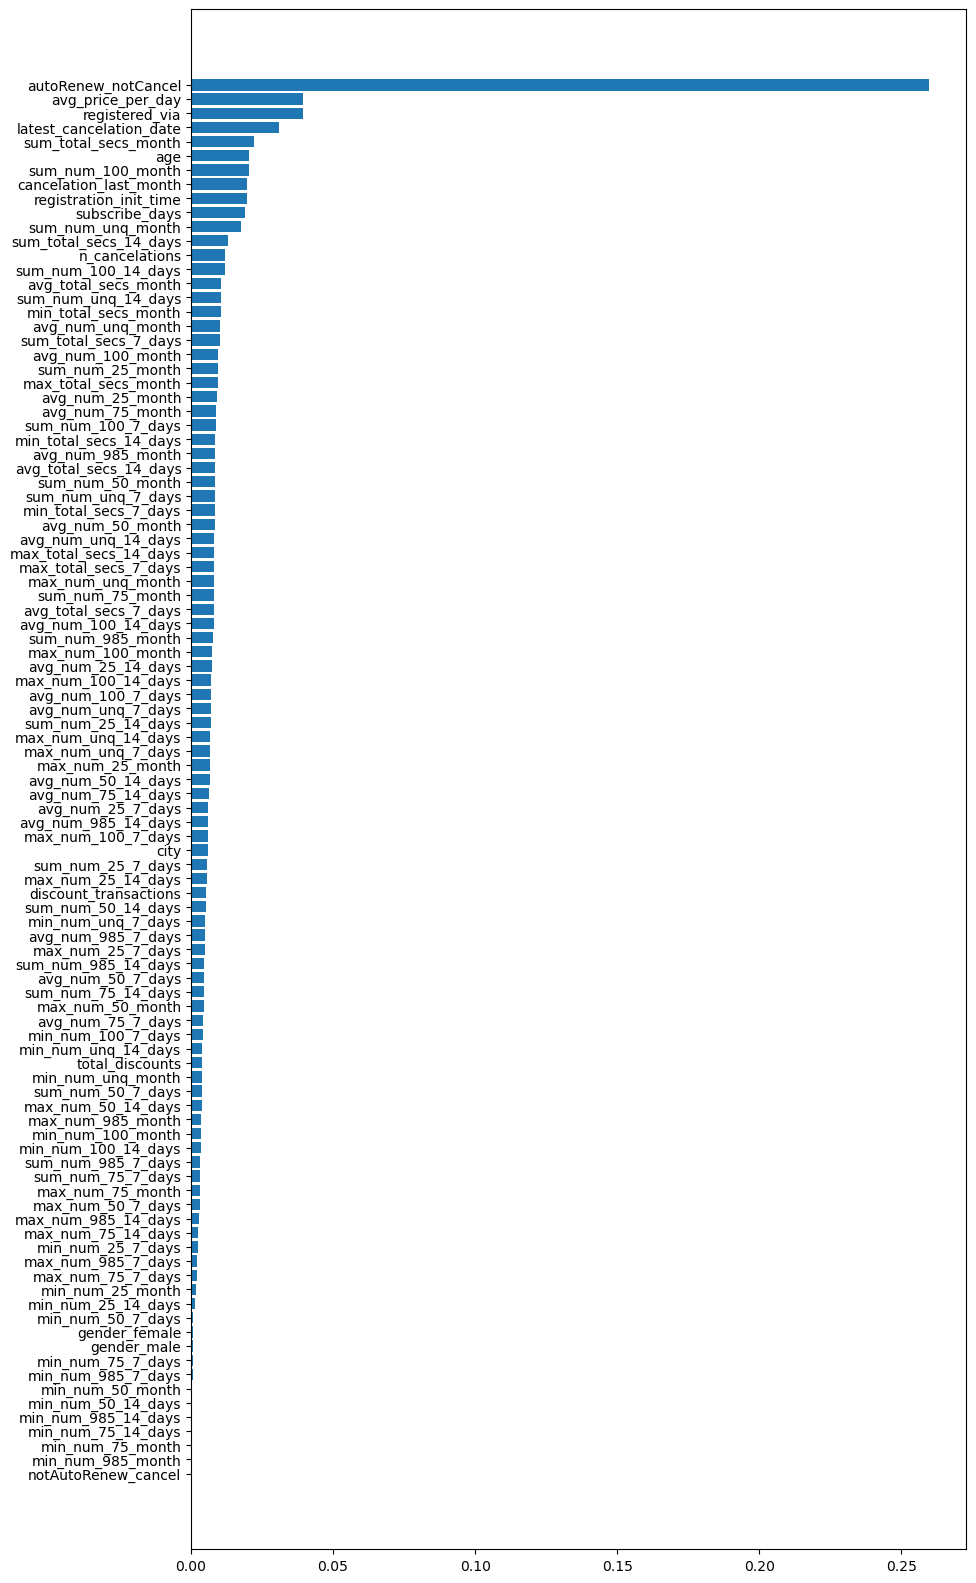

In [82]:
features = pd.DataFrame(zip(X_test.columns,rf.feature_importances_)).sort_values(1,ascending=True)

plt.figure(figsize=(10,20))
plt.barh(features[0],features[1])

### XGBoost

In [83]:
xgb = XGBClassifier(eta=0.05,eval_metric='logloss',scale_pos_weight=11)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [84]:
xgb_predict = xgb.predict(X_test)
xgb_predict_prob = xgb.predict_proba(X_test)

In [85]:
xgb_score = balanced_accuracy_score(y_test,xgb_predict)
xgb_score

0.8125630336520471

In [86]:
xgb_score_prob = log_loss(y_test,xgb_predict_prob[:,1])
xgb_score_prob

0.37838495640879855

In [87]:
confusion_matrix(y_test,xgb_predict)

array([[226797,  47304],
       [  5112,  20158]])

<BarContainer object of 99 artists>

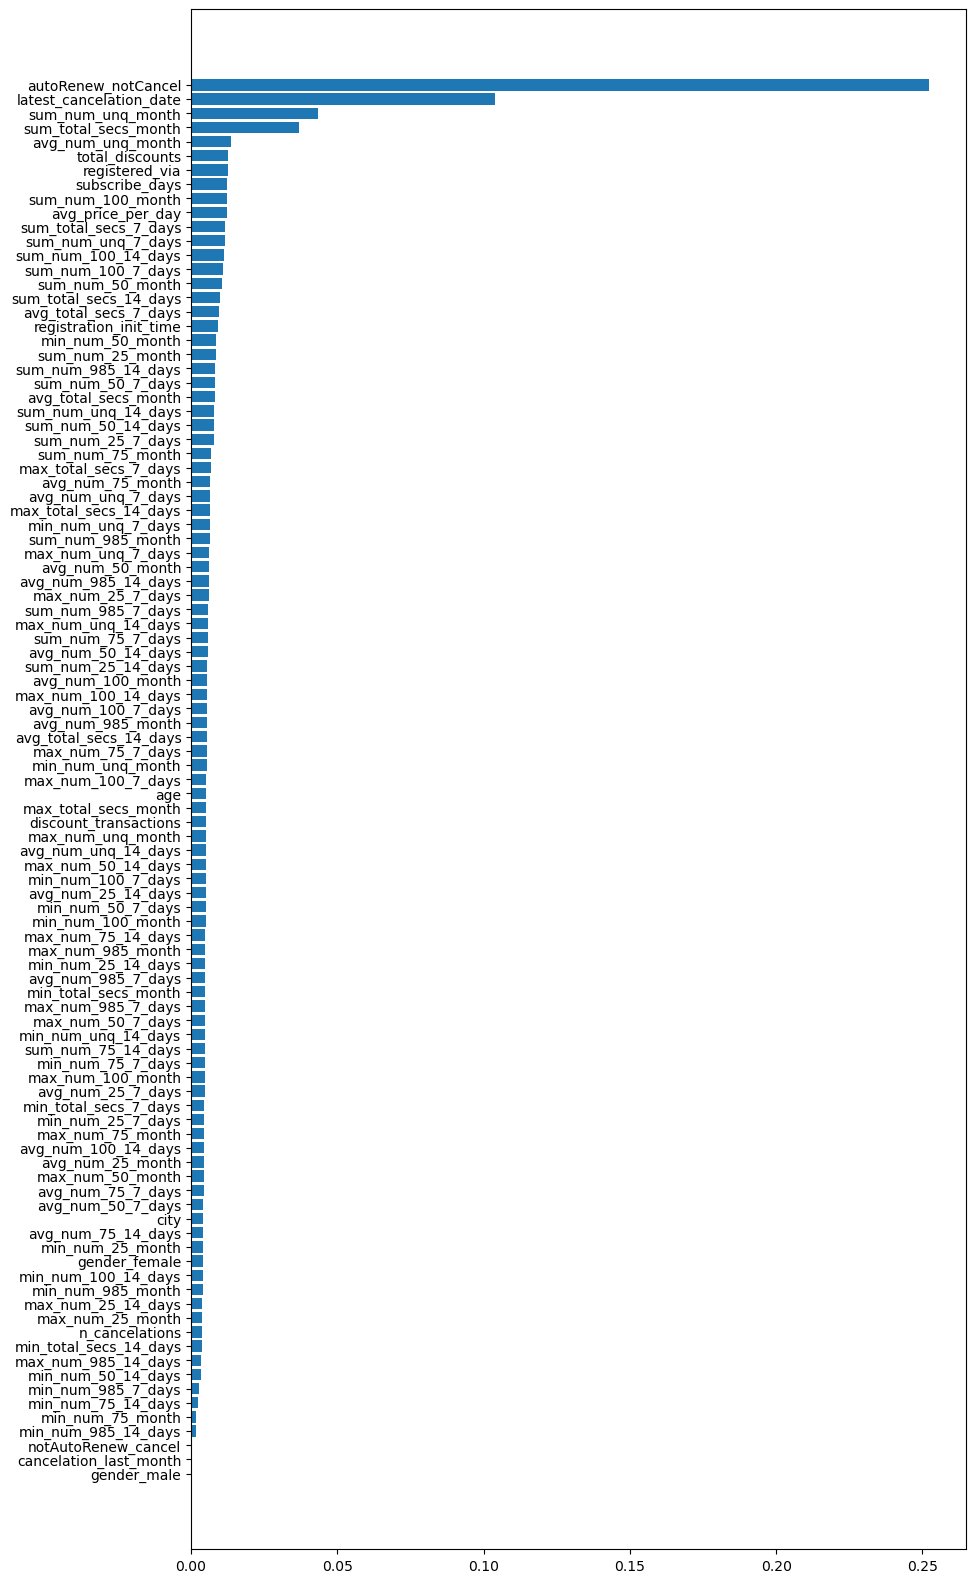

In [88]:
features = pd.DataFrame(zip(X_test.columns,xgb.feature_importances_)).sort_values(1,ascending=True)

plt.figure(figsize=(10,20))
plt.barh(features[0],features[1])

## Teste de Modelos

In [89]:
pd.DataFrame([('Logistic Regression',lr_score),('kNN',knn_score),('Random Forest',rf_score),('XGBoost',xgb_score)],columns=['Model','Score'])

,Model,Score
0,Logistic Regression,0.506206
1,kNN,0.510845
2,Random Forest,0.756491
3,XGBoost,0.812563
